Implementation of Human-level control through deep reinforcement learning, Mnih et. all
![](http://)# https://www.nature.com/articles/nature14236

In [212]:
import numpy as np
import random
import gym

In [213]:
from numpy import tanh
from scipy.special import softmax
import pdb
from collections import deque

In [214]:
class DQNNModel(object):
    '''
    Two layer neural net
    input X
    Z1 = dot(X, W1) + B1
    Z2 = tanh(Z1)
    Z3 = dot(Z2, W2) + B2
    y_hat = Z3
    
    Loss(L) = 0.5 * (y_hat - y)**2
    
    dL/dy_hat = y_hat-y
    dy_hat/dZ3 = y_hat-y
    dZ3/dW2 = Z2
    dZ3/dB2 = 1
    dZ3/dZ2 = W2
    dZ2/dZ1 = 1 - Z2^2
    dZ1/dW1 = X
    dZ1/dB1 = 1
    
    Using chain rule
    
    dL/dW2 = (y_hat-y)*Z2
    dL/dB2 = (y_hat-y)
    
    dL/dW1 = (y_hat-y)*W2*(1-Z2^2)*X
    (input,hidden) = (1,output)*(hidden,output)*(1,hidden)*(1,input)
    
    dL/dB1 = (y_hat-y)*W2*(1-Z2^2)
    
    
    '''
    def __init__(self, ninput, nhidden, noutput):
        self.ninput_ = ninput
        self.nhidden_ = nhidden
        self.noutput_ = noutput
        #initialize model weights
        #X=(1,input)
        self.W1_ = np.random.randn(ninput, nhidden) / np.sqrt(nhidden)
        self.B1_ = np.random.randn(1, nhidden) / np.sqrt(nhidden)
        self.W2_ = np.random.randn(nhidden, noutput) / np.sqrt(noutput)
        self.B2_ = np.random.randn(1, noutput) / np.sqrt(noutput)
        
        self.dW1_cache_ = 0.
        self.dB1_cache_ = 0.
        self.dW2_cache_ = 0.
        self.dB2_cache_ = 0.
    
    def __str__(self):
        return_str = ""
        for i,j in self.__dict__.items():
            return_str += str(i) + " " + str(j) + "\n"  
        return return_str
    
    def forward(self, x):
        #x=(1,input)
        #W1=(input,hidden)
        z1 = np.dot(x, self.W1_) + self.B1_ #(1,hidden)
        z2 = tanh(z1) #(1,hidden)
        z3 = np.dot(z2, self.W2_) + self.B2_ #(1,output)
        #W2=(hidden, output)
        y_hat = z3 #(1,output)
        return y_hat, z1, z2, z3, self.W1_, self.W2_
    
    def loss(self, y, y_hat):
        loss = 0.5 * (y_hat - y)**2
        return loss
    
    def backward(self, x, y, y_hat, z1, z2, z3, w1, w2, clip=True):
        #pdb.set_trace()
        dlogp = y_hat-y
        if(clip):
            np.clip(dlogp, -1, 1, out=dlogp)
        
        dB2 = dlogp # (1, output)
        dW2 = np.dot(z2.T, dlogp) #(hidden, output)
        
        dB1 = np.dot(dlogp, w2.T)*(1-(z2*z2)) #(1,hidden)
        dW1 = np.dot(x.T, dB1) #(input,hidden)
        return dW1, dB1, dW2, dB2
            
    
    def update_SGD(self, dW1, dB1, dW2, dB2, lr=1e-4):
        self.W1_ -= lr*dW1
        self.B1_ -= lr*dB1
        self.W2_ -= lr*dW2
        self.B2_ -= lr*dB2
        
    def get_weights(self):
        return self.W1_, self.B1_, self.W2_, self.B2_
    
    def put_weights(self, W1, B1, W2, B2):
        self.W1_ = W1
        self.B1_ = B1
        self.W2_ = W2
        self.B2_ = B2
    
    def put_from_model(self, model):
        self.W1_ = model.W1_
        self.B1_ = model.B1_
        self.W2_ = model.W2_
        self.B2_ = model.B2_

        
    def update_RMSProp(self, dW1, dB1, dW2, dB2, lr=1e-4):
        decay_rate = 0.9
        eps = 1e-4
        
        self.dW1_cache_ = decay_rate * self.dW1_cache_ + (1 - decay_rate) * (dW1)**2
        self.W1_ += - lr * dW1 / (np.sqrt(self.dW1_cache_) + eps)

        self.dW2_cache_ = decay_rate * self.dW2_cache_ + (1 - decay_rate) * (dW2)**2
        self.W2_ += - lr * dW2 / (np.sqrt(self.dW2_cache_) + eps)

        self.dB1_cache_ = decay_rate * self.dB1_cache_ + (1 - decay_rate) * (dB1)**2
        self.B1_ += - lr * dB1 / (np.sqrt(self.dB1_cache_) + eps)

        self.dB2_cache_ = decay_rate * self.dB2_cache_ + (1 - decay_rate) * (dB2)**2
        self.B2_ += - lr * dB2 / (np.sqrt(self.dB2_cache_) + eps)        
                

In [215]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [216]:
state = env.reset()
INPUT_UNITS = state.shape[0]
HIDDEN_UNITS = 100
OUTPUT_UNITS = env.action_space.n
model = DQNNModel(INPUT_UNITS, HIDDEN_UNITS, OUTPUT_UNITS)
target_model = DQNNModel(INPUT_UNITS, HIDDEN_UNITS, OUTPUT_UNITS)


In [217]:
num_episodes = 10000

experience_replay_size = 500
experience_replay_queue_max = 10000

copy_model_after = 5
copy_model_counter = 0

display_after = 20
display_after_counter = 0

epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.995

total_steps = 0
total_episode_steps_rs = []
episode_steps_rs = []
batch_loss_rs = []

replay_queue = deque(maxlen=experience_replay_queue_max)

for episode in range(num_episodes):
    episode_steps = 0
    while True:
        state = state.reshape(1,-1)
        y_hat, _, _, _, _, _ = model.forward(state)
        action_values = y_hat
        actions_sm = softmax(action_values)
        
        #exploration vs exploitation
        if epsilon > random.random():
            action = 0 if 0.5>random.random() else 1
        else:
            action = 0 if actions_sm[0][0]>random.random() else 1        
        
        new_state, reward, done, info = env.step(action)
        episode_steps += 1
        
        replay_queue.append([state,action,reward-done,new_state,done])

        state = new_state
        total_steps += 1

        if (total_steps%experience_replay_size == 0):
            batch_loss = 0.
            batch = random.sample(list(replay_queue), experience_replay_size)
            
            dW1, dB1, dW2, dB2 = 0.,0.,0.,0.
            for i,obs in enumerate(batch):
                s, a, r, n_s, d = obs
                n_s = n_s.reshape(1,-1)
                target = np.zeros((1,env.action_space.n))
                if d:
                    target[0][a] = r
                else:
                    t_val,_,_,_,_,_ = target_model.forward(n_s)
                    target[0][a] = r
                    target += 0.99 * (t_val)


                y_hat, z1, z2, z3, w1, w2 = model.forward(s)
                y = target
                dw1, db1, dw2, db2 = model.backward(s, y, y_hat, z1, z2, z3, w1, w2, clip=True)
                
                #dW1 += dw1
                #dB1 += db1
                #dW2 += dw2
                #dB2 += db2
                #model.update_SGD(dw1, db1, dw2, db2)
                model.update_RMSProp(dw1, db1, dw2, db2)
                batch_loss += model.loss(y, y_hat).mean()
            
            
            #model.update_SGD(dW1, dB1, dW2, dB2)
            #update target model with model
            copy_model_counter += 1
            if(copy_model_counter%copy_model_after == 0):
                target_model.put_from_model(model)
            
            average_loss = batch_loss / len(batch)                         
            batch_loss_rs.append(average_loss)
            display_after_counter += 1

            if epsilon > epsilon_min:
                epsilon *= epsilon_decay
            
            if (display_after_counter%display_after == 0):
                episode_steps_buffer = episode_steps_rs
                episode_loss_buffer = batch_loss_rs[-display_after:]
                #print(episode_loss_buffer)
                min_steps = np.min(episode_steps_buffer)
                max_steps = np.max(episode_steps_buffer)
                avg_steps = np.mean(episode_steps_buffer)
                print("Episode %d, batch episodes %d, max %d, min %d, avg %d steps, avg loss %f"%(episode+1, len(episode_steps_rs),max_steps, 
                                                                                                  min_steps, avg_steps, np.mean(episode_loss_buffer)))
                episode_steps_rs = []
                                
        if done:
            state = env.reset()
            episode_steps_rs.append(episode_steps)
            total_episode_steps_rs.append(episode_steps)
            break
            

Episode 455, batch episodes 454, max 72, min 8, avg 21 steps, avg loss 2.462729
Episode 935, batch episodes 480, max 95, min 8, avg 20 steps, avg loss 6.006867
Episode 1410, batch episodes 475, max 107, min 8, avg 20 steps, avg loss 2.618266
Episode 1943, batch episodes 533, max 84, min 8, avg 18 steps, avg loss 6.853564
Episode 2541, batch episodes 598, max 66, min 8, avg 16 steps, avg loss 7.826777
Episode 3053, batch episodes 512, max 128, min 9, avg 19 steps, avg loss 9.559580
Episode 3416, batch episodes 363, max 121, min 9, avg 27 steps, avg loss 3.165634
Episode 3695, batch episodes 279, max 162, min 11, avg 35 steps, avg loss 22.669366
Episode 3924, batch episodes 229, max 204, min 10, avg 43 steps, avg loss 27.043493
Episode 4040, batch episodes 116, max 244, min 8, avg 86 steps, avg loss 12.884468
Episode 4099, batch episodes 59, max 493, min 12, avg 166 steps, avg loss 17.627596
Episode 4150, batch episodes 51, max 363, min 11, avg 199 steps, avg loss 3.709026
Episode 4206, 

Episode 6646, batch episodes 33, max 500, min 149, avg 300 steps, avg loss 4.143050
Episode 6666, batch episodes 20, max 500, min 500, avg 500 steps, avg loss 2.380700
Episode 6701, batch episodes 35, max 500, min 136, avg 275 steps, avg loss 3.619417
Episode 6721, batch episodes 20, max 500, min 500, avg 500 steps, avg loss 2.739123
Episode 6744, batch episodes 23, max 500, min 192, avg 454 steps, avg loss 2.018464
Episode 6772, batch episodes 28, max 500, min 173, avg 355 steps, avg loss 2.815560
Episode 6793, batch episodes 21, max 500, min 200, avg 474 steps, avg loss 2.806578
Episode 6820, batch episodes 27, max 500, min 194, avg 366 steps, avg loss 2.810822
Episode 6849, batch episodes 29, max 500, min 180, avg 350 steps, avg loss 3.191519
Episode 6878, batch episodes 29, max 500, min 176, avg 337 steps, avg loss 3.071311
Episode 6905, batch episodes 27, max 500, min 203, avg 362 steps, avg loss 3.436123
Episode 6929, batch episodes 24, max 500, min 159, avg 433 steps, avg loss 2

Episode 9296, batch episodes 27, max 500, min 159, avg 373 steps, avg loss 3.352319
Episode 9319, batch episodes 23, max 500, min 179, avg 414 steps, avg loss 3.153918
Episode 9341, batch episodes 22, max 500, min 261, avg 458 steps, avg loss 2.508782
Episode 9372, batch episodes 31, max 500, min 183, avg 319 steps, avg loss 3.077867
Episode 9399, batch episodes 27, max 500, min 175, avg 383 steps, avg loss 2.606871
Episode 9424, batch episodes 25, max 500, min 188, avg 386 steps, avg loss 2.984353
Episode 9456, batch episodes 32, max 500, min 141, avg 326 steps, avg loss 3.038489
Episode 9481, batch episodes 25, max 500, min 181, avg 396 steps, avg loss 3.335713
Episode 9504, batch episodes 23, max 500, min 244, avg 434 steps, avg loss 2.277670
Episode 9529, batch episodes 25, max 500, min 228, avg 396 steps, avg loss 3.209297
Episode 9554, batch episodes 25, max 500, min 200, avg 399 steps, avg loss 3.245148
Episode 9583, batch episodes 29, max 500, min 182, avg 348 steps, avg loss 2

In [218]:
from matplotlib import pyplot as plt

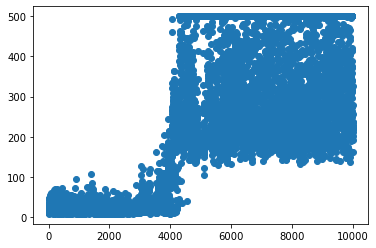

In [219]:
plt.scatter(np.array(range(len(total_episode_steps_rs))), total_episode_steps_rs)

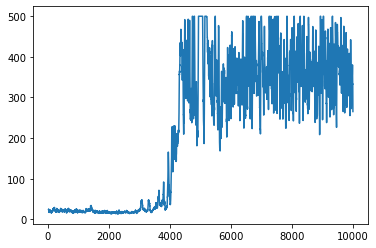

In [220]:
import pandas as pd
s1 = pd.Series(total_episode_steps_rs).rolling(20).mean()
s1.dropna(inplace=True)
plt.plot(s1)

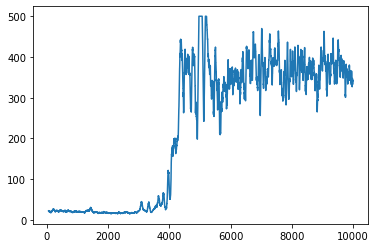

In [221]:
import pandas as pd
s2 = pd.Series(total_episode_steps_rs).rolling(50).mean()
s2.dropna(inplace=True)
plt.plot(s2)